<a href="https://colab.research.google.com/github/antndlcrx/LLM-for-Social-Science-Research/blob/main/synth_sampling_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    PreTrainedModel,
    PreTrainedTokenizer,
    PreTrainedTokenizerFast,
)
import torch
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import os
from typing import List, Dict, Tuple, Any
import json

from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
mount_point = '/content/drive'
from google.colab import drive
drive.mount(mount_point)

Mounted at /content/drive


In [3]:
!git clone https://github.com/antndlcrx/LLM-for-Social-Science-Research.git

Cloning into 'LLM-for-Social-Science-Research'...
remote: Enumerating objects: 403, done.
remote: Counting objects: 100% (164/164), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 403 (delta 98), reused 78 (delta 34), pack-reused 239 (from 1)
Receiving objects: 100% (403/403), 16.81 MiB | 14.59 MiB/s, done.
Resolving deltas: 100% (239/239), done.


In [4]:
from google.colab import userdata
HF_TOKEN = userdata.get("HF_LLAMA31")

In [5]:
# model_name = "meta-llama/Meta-Llama-3.1-8B"
# model_name = "meta-llama/Llama-3.1-8B-Instruct"
model_name = "oxford-llms/llama3-1-ox-llms-8b-sft-full"

tokenizer = AutoTokenizer.from_pretrained(model_name, token=HF_TOKEN,
                                          padding_side='left')
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/335 [00:00<?, ?B/s]

In [6]:
model = AutoModelForCausalLM.from_pretrained(model_name,
                                             trust_remote_code=True,
                                             torch_dtype=torch.float16,
                                             device_map='auto',
                                             token=HF_TOKEN,
                                             )

config.json:   0%|          | 0.00/886 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

In [ ]:
# pipeline = transformers.pipeline(
#     "text-generation",
#     model=model_id,
#     model_kwargs={"torch_dtype": torch.bfloat16},
#     device_map="auto",
# )

In [7]:
directory = 'LLM-for-Social-Science-Research/mappings/ESS/2023'

survey_mappings = {}

for filename in os.listdir(directory):
    if filename.endswith('.json'):
        section_name = os.path.splitext(filename)[0]

        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
            survey_mappings[section_name] = json.load(file)

In [8]:
ess = pd.read_csv("LLM-for-Social-Science-Research/ESS11.csv")

<ipython-input-8-669844dd4aa6>:1: DtypeWarning: Columns (548) have mixed types. Specify dtype option on import or set low_memory=False.
  ess = pd.read_csv("LLM-for-Social-Science-Research/ESS11.csv")


In [9]:
class Mapper:
    def __init__(self, survey_mappings: Dict[str, Dict[str, Any]]):
        self.survey_mappings = survey_mappings
        # Build a mapping from feature names to their sections for quick lookup
        self.feature_to_section = {
            feature: section
            for section, features in self.survey_mappings.items()
            for feature in features
        }

    def map_value(self, feature_name: str, value):
        section = self.feature_to_section.get(feature_name)
        if not section:
            return str(value)  # Feature not found in mappings

        feature_mapping = self.survey_mappings[section].get(feature_name)
        if not feature_mapping:
            return str(value)  # Feature mapping not found

        values_mapping = feature_mapping.get('values', {})
        if pd.isnull(value):
            return "Missing"

        if isinstance(value, float) and value.is_integer():
            value_key = str(int(value))
        elif isinstance(value, (int, np.integer)):
            value_key = str(value)
        else:
            value_key = str(value)

        return values_mapping.get(value_key, str(value))

    def fill_prompt(self, respondent: pd.Series, prompt_template: str):
        placeholders = {}
        placeholder_pattern = re.compile(r"\{(\w+)\}")
        placeholder_names = placeholder_pattern.findall(prompt_template)

        for placeholder in placeholder_names:
            if placeholder in respondent:
                value = respondent[placeholder]
                if placeholder in ['agea']:
                    # Handle numeric fields separately
                    placeholders[placeholder] = str(int(value)) if pd.notnull(value) else f"unknown {placeholder}"
                else:
                    mapped_value = self.map_value(placeholder, value)
                    placeholders[placeholder] = mapped_value
            else:
                placeholders[placeholder] = "Unknown"

        filled_prompt = prompt_template.format(**placeholders)
        return filled_prompt


In [10]:
mapper = Mapper(survey_mappings)

In [150]:
def generate_dialog(survey: pd.DataFrame, question: str):
    """
    """

    profile_prompt = """Imagine you are a {agea}-year old {gndr} living in {cntry} in {essround}. Your highest education is {eisced}."""

    system_dict = {
        "role": "system",
        "content": """You are a helpful AI assistant for public opinion research. You are skillful at using your knowledge to make good judgement about people's preferences when given some background information."""
        }

    question = question

    messages = []
    for idx, respondent in survey.iterrows():
        filled_prompt = mapper.fill_prompt(respondent, profile_prompt)
        user_dict = {"role": "user",
                     "content": filled_prompt + question}
        message = [ user_dict] #system dict
        messages.append(message)

    return messages

In [92]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def make_predictions(dialogs, batch_size=8):
    """
    Generate predictions for a batch of dialogs.

    Args:
        dialogs (list): A list of dictionaries containing dialogs to process.
        batch_size (int): Number of dialogs to process in a single batch.

    Returns:
        list: A list of generated completions for the input dialogs.
    """
    completions = []

    with tqdm(total=len(dialogs), desc="Generating predictions", unit="prompt") as pbar:
        for i in range(0, len(dialogs), batch_size):
            batch_dialogs = dialogs[i:i + batch_size]

            inputs = tokenizer.apply_chat_template(
                batch_dialogs,
                tokenize=True,
                add_generation_prompt=True,
                truncation=True, padding=True,
                return_tensors="pt"
                ).to(device)

            with torch.no_grad():
                outputs = model.generate(
                    inputs,
                    max_new_tokens=32,
                    temperature=1,
                    do_sample=True,
                    eos_token_id=tokenizer.eos_token_id,
                    pad_token_id=tokenizer.pad_token_id,
                )

            batch_completions = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
            completions.extend(batch_completions)
            pbar.update(len(batch_dialogs))

    return completions


def extract_answers(responses):
    """
    Extracts only the answer part from a list of text responses.

    Args:
        responses (list): A list of response strings, where each string is a complete dialogue.

    Returns:
        list: A list of extracted answers (strings).
    """
    answers = []
    for response in responses:
        # Use regex to match everything after 'assistant\n'
        match = re.search(r"<\|assistant\|>\s*(.+)", response, re.DOTALL)
        if match:
            # Strip whitespace and newlines from the answer
            answer = match.group(1).strip()
            answers.append(answer)
        else:
            # If no match, add a placeholder or leave empty
            answers.append("No answer found")
    return answers

In [137]:
random_subset = ess.sample(300, random_state=42)

In [151]:
question = """
Question: How interested would you say you are in politics? Provide a one-word answer using only categories from the list: "Very interested", "Quite interested", "Hardly interested", "Not at all interested", "Refusal", "Don't know". Do not respond starting with "I would say" or similar ways. Only provide one of the given categories.
"""

dialogs = generate_dialog(random_subset, question)

In [152]:
dialogs[0]

[{'role': 'user',
  'content': 'Imagine you are a 35-year old Male living in Austria in 2023. Your highest education is Upper secondary education.\nQuestion: How interested would you say you are in politics? Provide a one-word answer using only categories from the list: "Very interested", "Quite interested", "Hardly interested", "Not at all interested", "Refusal", "Don\'t know". Do not respond starting with "I would say" or similar ways. Only provide one of the given categories.\n'}]

In [153]:
responces = make_predictions(dialogs)

Generating predictions: 100%|██████████| 300/300 [02:38<00:00,  1.90prompt/s]


In [ ]:
responces

In [155]:
response_list = [response.rstrip(".") for response in extract_answers(responces)]
random_subset['predictions_polintr'] = response_list

In [129]:
#@title Aggregate Comparison

def plot_variable_distribution(random_subset, variable_name, mapper, horizontal=False):
    """
    Plot the distribution of a variable as original and predicted proportions.

    Args:
        random_subset (DataFrame): The dataset containing the data.
        variable_name (str): The name of the variable to plot.
        mapper (object): An object with a `map_value` method for mapping values.
        horizontal (bool): If True, plots horizontal bar plots. Defaults to False.
    """
    # Map values for the original and predicted columns
    predictions_column = f'predictions_{variable_name}'
    mapped_column = f'{variable_name}_mapped'

    random_subset[predictions_column] = random_subset[predictions_column].apply(lambda x: mapper.map_value(variable_name, x))
    random_subset[mapped_column] = random_subset[variable_name].apply(lambda x: mapper.map_value(variable_name, x))

    # Automatically detect the order of categories from the data
    unique_categories = sorted(
        set(random_subset[mapped_column].dropna().unique()).union(
            set(random_subset[predictions_column].dropna().unique())
        ),
        key=lambda x: str(x).lower()  # Sort categories alphabetically (case-insensitive)
    )

    # Calculate category proportions for original data
    original_proportions = random_subset[mapped_column].value_counts(normalize=True)

    # Calculate category proportions for model predictions
    response_proportions = random_subset[predictions_column].value_counts(normalize=True)

    # Determine maximum limit for consistent scaling
    max_limit = max(original_proportions.max(), response_proportions.max()) + 0.1

    # Create subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))

    # Choose plot kind based on horizontal flag
    plot_kind = 'barh' if horizontal else 'bar'

    # Plot original survey data distribution
    original_proportions.plot(
        kind=plot_kind,
        color='skyblue',
        edgecolor='black',
        ax=axes[0]
    )
    axes[0].set_title(f'Original Data - {variable_name}', fontsize=14)
    if horizontal:
        axes[0].set_xlabel('Proportion', fontsize=12)
        axes[0].set_ylabel('Response', fontsize=12)
        axes[0].set_xlim(0, max_limit)
    else:
        axes[0].set_xlabel('Response', fontsize=12)
        axes[0].set_ylabel('Proportion', fontsize=12)
        axes[0].set_ylim(0, max_limit)

    # Plot model predictions distribution
    response_proportions.plot(
        kind=plot_kind,
        color='salmon',
        edgecolor='black',
        ax=axes[1]
    )
    axes[1].set_title(f'Model Predictions - {variable_name}', fontsize=14)
    if horizontal:
        axes[1].set_xlabel('Proportion', fontsize=12)
        axes[1].set_ylabel('Response', fontsize=12)
        axes[1].set_xlim(0, max_limit)
    else:
        axes[1].set_xlabel('Response', fontsize=12)
        axes[1].set_ylabel('Proportion', fontsize=12)
        axes[1].set_ylim(0, max_limit)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plots
    plt.show()


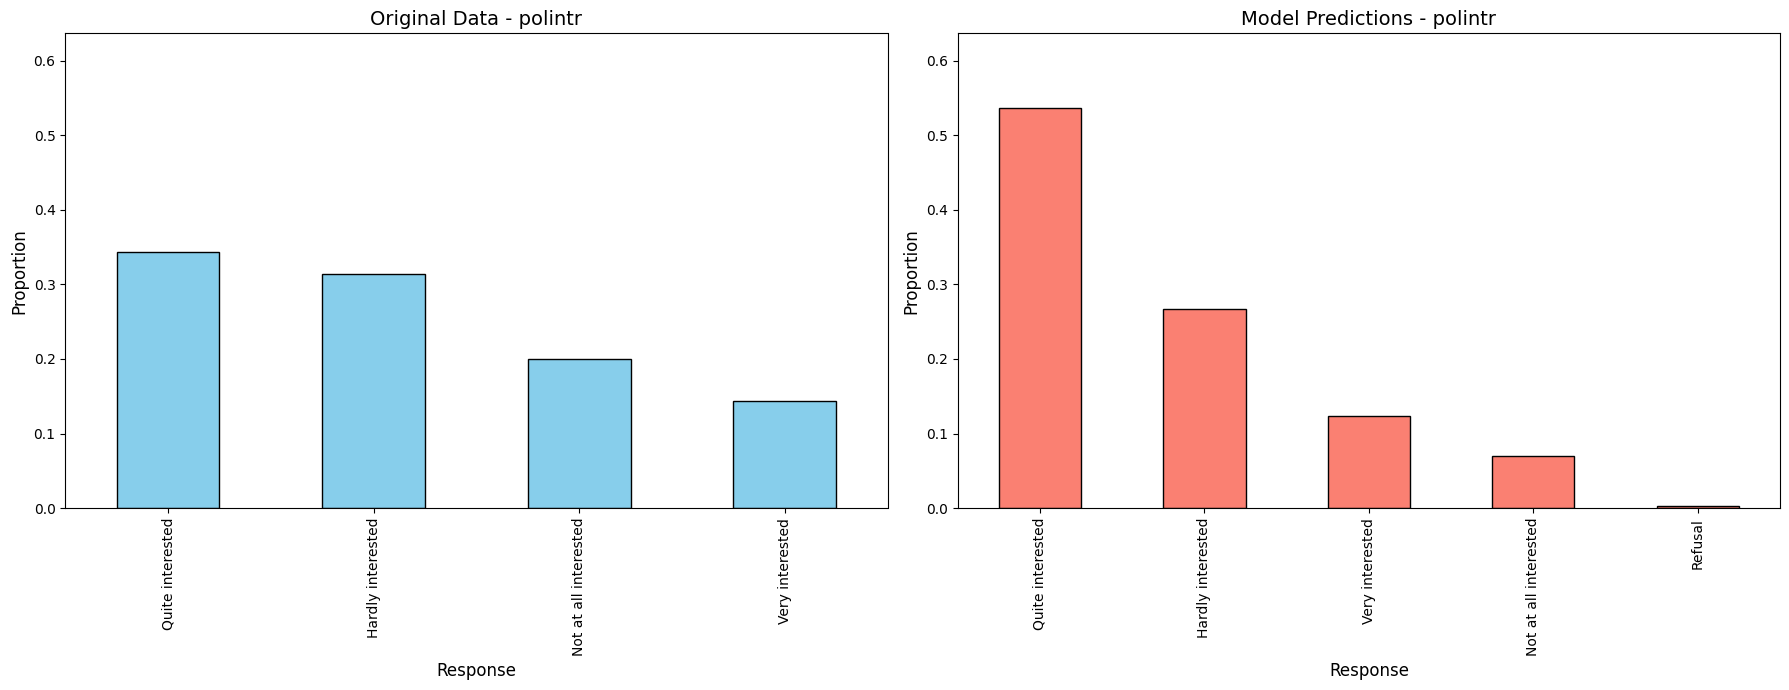

In [156]:
plot_variable_distribution(random_subset, 'polintr', mapper)


In [42]:
random_subset['predictions_weasoff'].unique()

array(['never', 'sometimes', 'rarely', 'often', 'don´t know',
       "don't know", 'refuse to answer'], dtype=object)

In [62]:
#@title by gndr
def plot_gender_distributions(random_subset, variable_name, mapper):
    # Map values for the original and predicted columns
    predictions_column = f'predictions_{variable_name}'
    mapped_column = f'{variable_name}_mapped'

    random_subset[predictions_column] = random_subset[predictions_column].apply(lambda x: mapper.map_value(variable_name, x))
    random_subset[mapped_column] = random_subset[variable_name].apply(lambda x: mapper.map_value(variable_name, x))

    # Automatically detect the order of categories from the data
    unique_categories = sorted(
        set(random_subset[mapped_column].dropna().unique()).union(
            set(random_subset[predictions_column].dropna().unique())
        ),
        key=lambda x: str(x).lower()  # Sort categories alphabetically (case-insensitive)
    )

    # Group data by gender
    gender_groups = random_subset.groupby('gndr')

    # Create a figure with 2 rows and 2 columns
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))
    axes = axes.flatten()  # Flatten axes for easier indexing

    # Loop through the genders and plot for both original and predictions
    for idx, (gender, group) in enumerate(gender_groups):
        # Calculate category proportions for original data
        original_proportions_gender = group[mapped_column].value_counts(normalize=True)
        # Reindex to match the detected order, filling missing values with 0
        original_proportions_gender = original_proportions_gender.reindex(unique_categories, fill_value=0)

        # Calculate category proportions for model predictions
        response_proportions_gender = group[predictions_column].value_counts(normalize=True)
        # Reindex to match the detected order, filling missing values with 0
        response_proportions_gender = response_proportions_gender.reindex(unique_categories, fill_value=0)

        # Determine maximum y-value for consistent scaling
        max_y = max(original_proportions_gender.max(), response_proportions_gender.max()) + 0.1

        # Plot original data distribution
        original_proportions_gender.plot(
            kind='bar',
            color='skyblue',
            edgecolor='black',
            ax=axes[idx * 2]  # Even index for original data
        )
        axes[idx * 2].set_title(f"Original Data - {variable_name} ({'Men' if gender == 1 else 'Women'})", fontsize=14)
        axes[idx * 2].set_xlabel('Response', fontsize=12)
        axes[idx * 2].set_ylabel('Proportion', fontsize=12)
        axes[idx * 2].set_xticklabels(original_proportions_gender.index, rotation=45, ha='right', fontsize=10)
        axes[idx * 2].set_ylim(0, max_y)  # Set y-axis limit

        # Plot model predictions distribution
        response_proportions_gender.plot(
            kind='bar',
            color='salmon',
            edgecolor='black',
            ax=axes[idx * 2 + 1]  # Odd index for predictions
        )
        axes[idx * 2 + 1].set_title(f"Model Predictions - {variable_name} ({'Men' if gender == 1 else 'Women'})", fontsize=14)
        axes[idx * 2 + 1].set_xlabel('Response', fontsize=12)
        axes[idx * 2 + 1].set_ylabel('Proportion', fontsize=12)
        axes[idx * 2 + 1].set_xticklabels(response_proportions_gender.index, rotation=45, ha='right', fontsize=10)
        axes[idx * 2 + 1].set_ylim(0, max_y)  # Set y-axis limit

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plots
    plt.show()


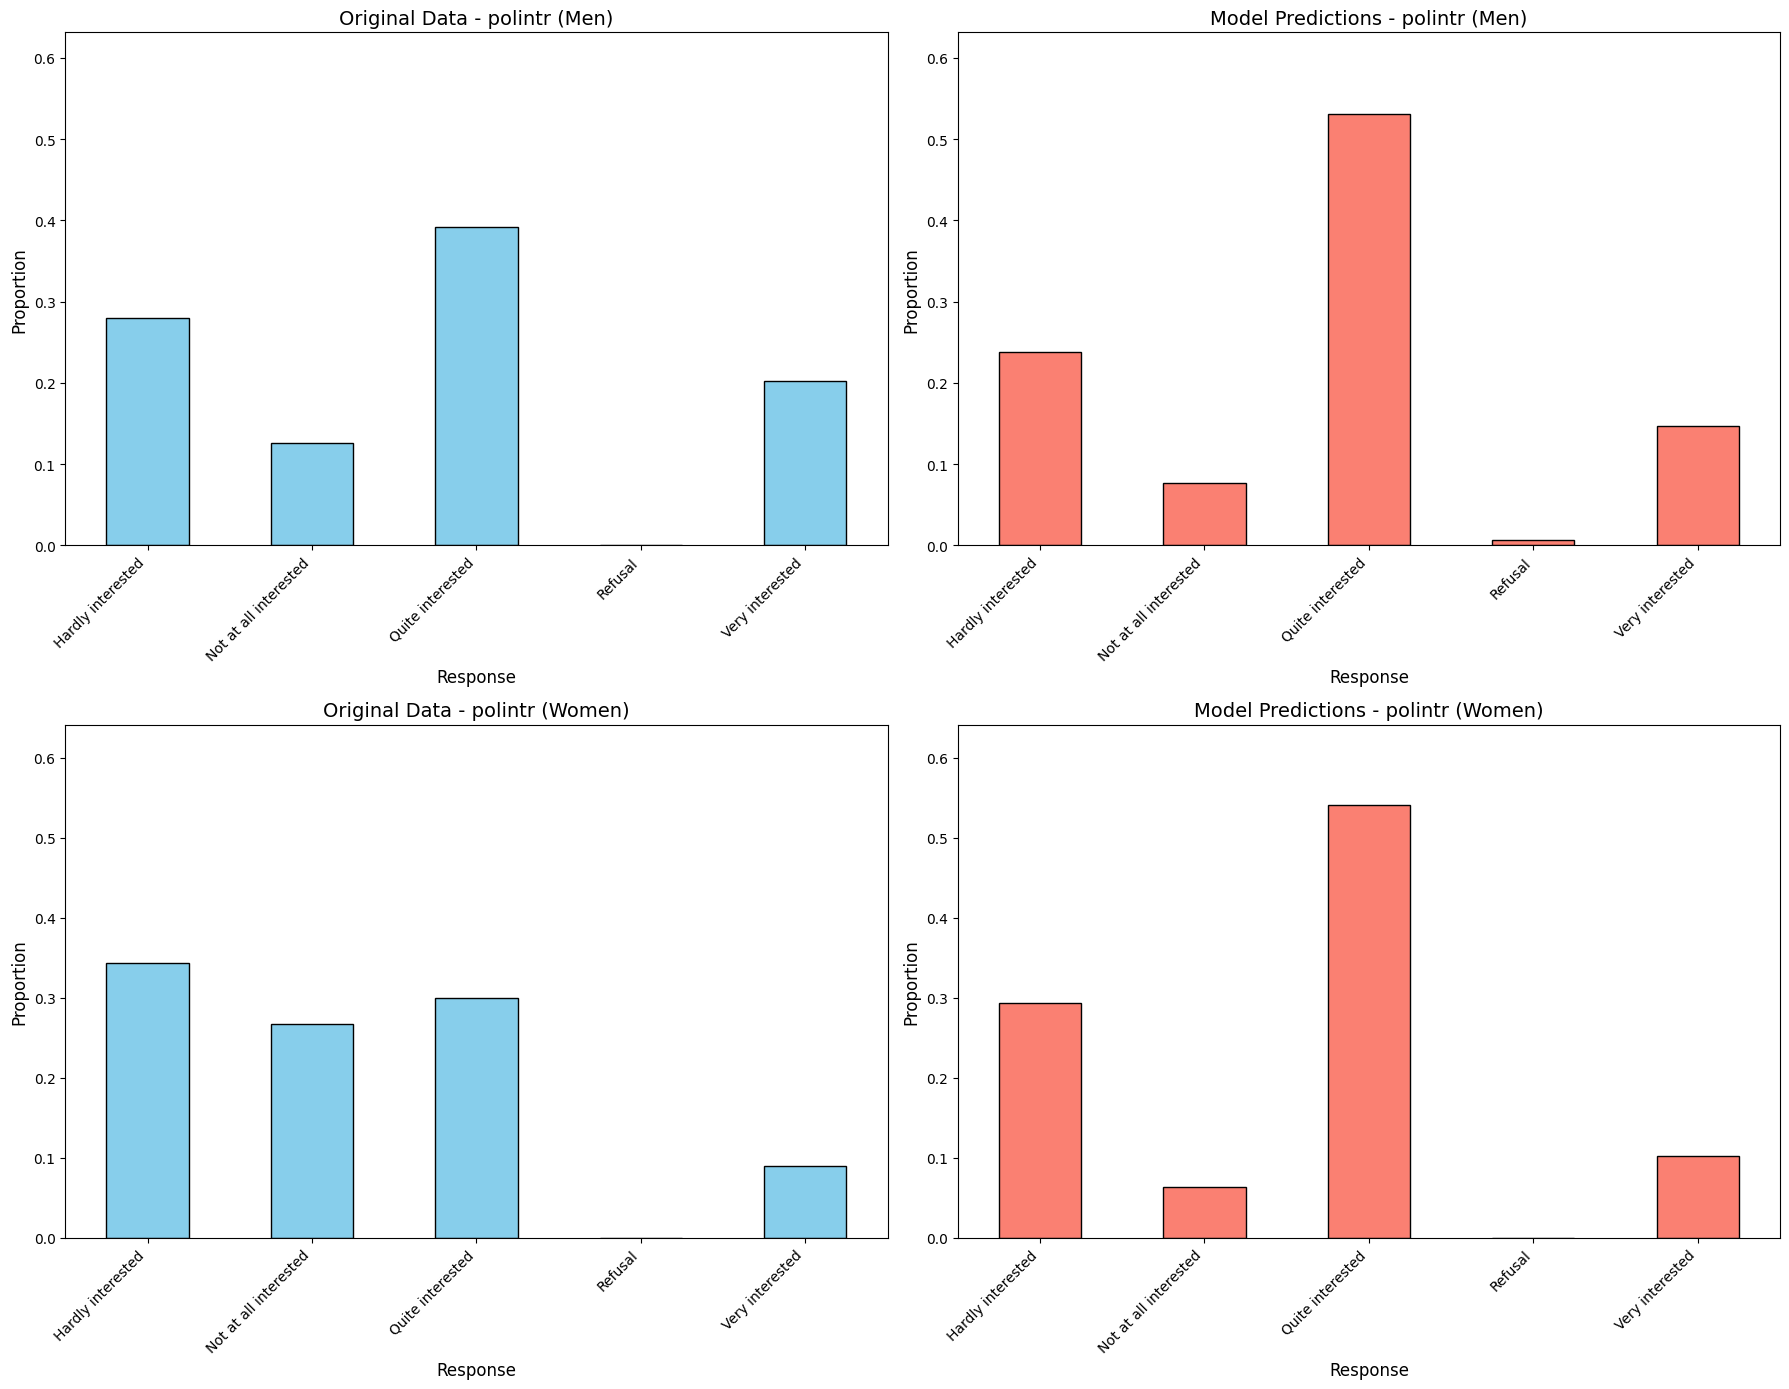

In [157]:
plot_gender_distributions(random_subset, 'polintr', mapper)


## 0-10 scale

In [ ]:
question = """
        Question: On the whole, how satisfied are you with the present state of the economy in the country? Please respond using a 0-10 scale where 0 means "extremely dissatisfied" and 10 means "extremely satisfied". Only provide the number corresponding to your opinion on the given scale."""


dialogs = generate_dialog(random_subset, question)

In [ ]:
responces = make_predictions(dialogs)

In [142]:
response_list = [response.rstrip(".") for response in extract_answers(responces)]
random_subset['predictions_stfeco'] = response_list

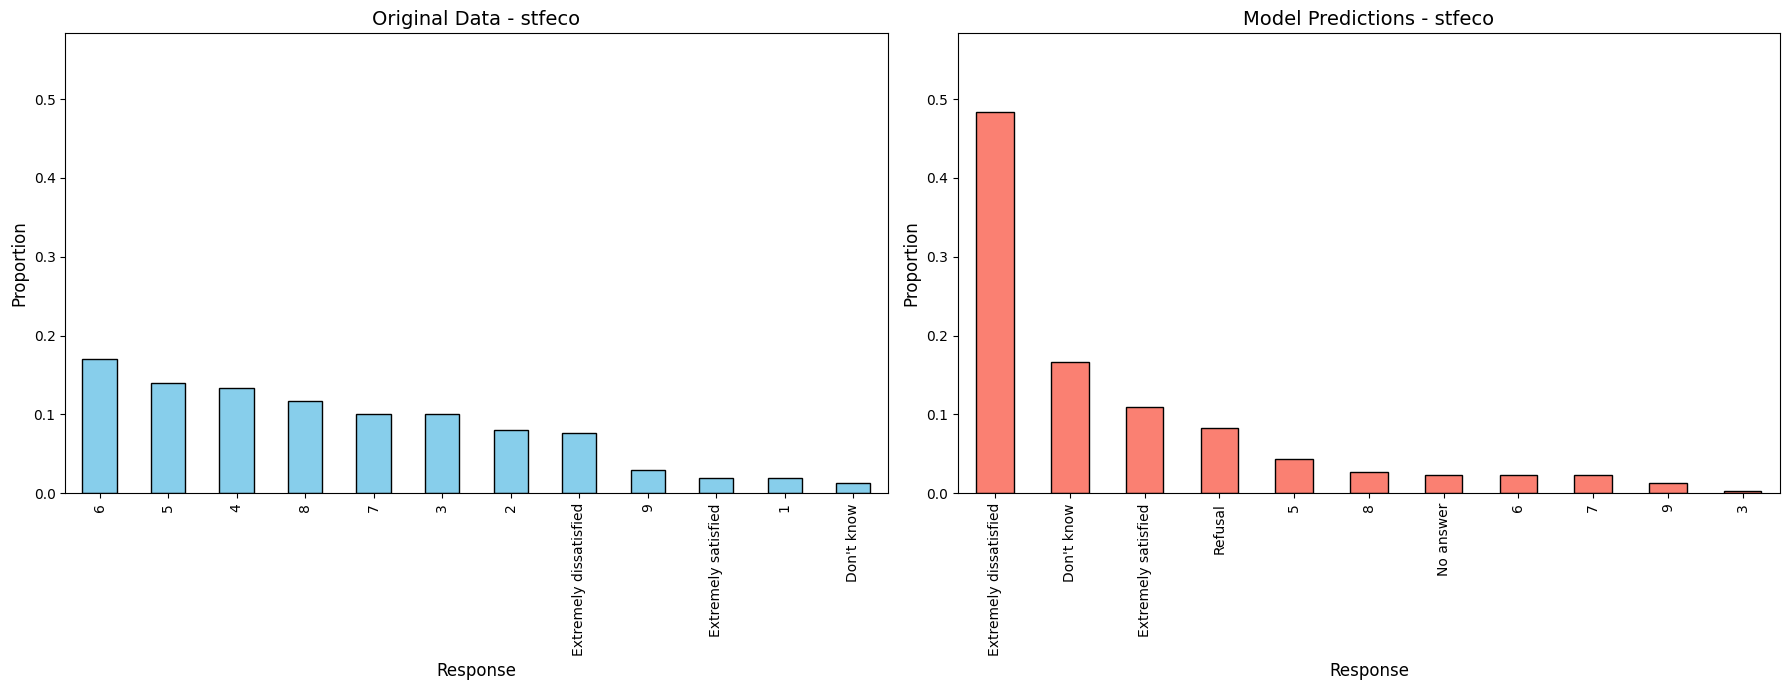

In [143]:
plot_variable_distribution(random_subset, 'stfeco', mapper)


## Voting

In [104]:
subset_germany_random = ess[ess['cntry'] == 'DE'].sample(300, random_state=42)

In [131]:
question = """
        Question: Which political party do you feel closest to? Please respond with just the party name of your preference. The available categories are "Christian Democratic Union/Christian Social Union (CDU/CSU)", "Social Democratic Party (SPD)", "The Left (Die Linke)", "Alliance 90/The Greens (Bündnis 90/Die Grünen)", "Free Democratic Party (FDP)", "Alternative for Germany (AFD)", "Free Voters (Freie Wähler)", "Grassroots Democratic Party of Germany (dieBasis)", "Die PARTEI", "Other", "Not applicable", "Refusal", "Don't know". Only provide one of the given categories as an answer."""


dialogs = generate_dialog(subset_germany_random, question)

In [132]:
responces = make_predictions(dialogs)

Generating predictions: 100%|██████████| 300/300 [10:02<00:00,  2.01s/prompt]


In [ ]:
responces[0:10]

In [133]:
response_list = [response.rstrip(".") for response in extract_answers(responces)]
subset_germany_random['predictions_prtclgde'] = response_list

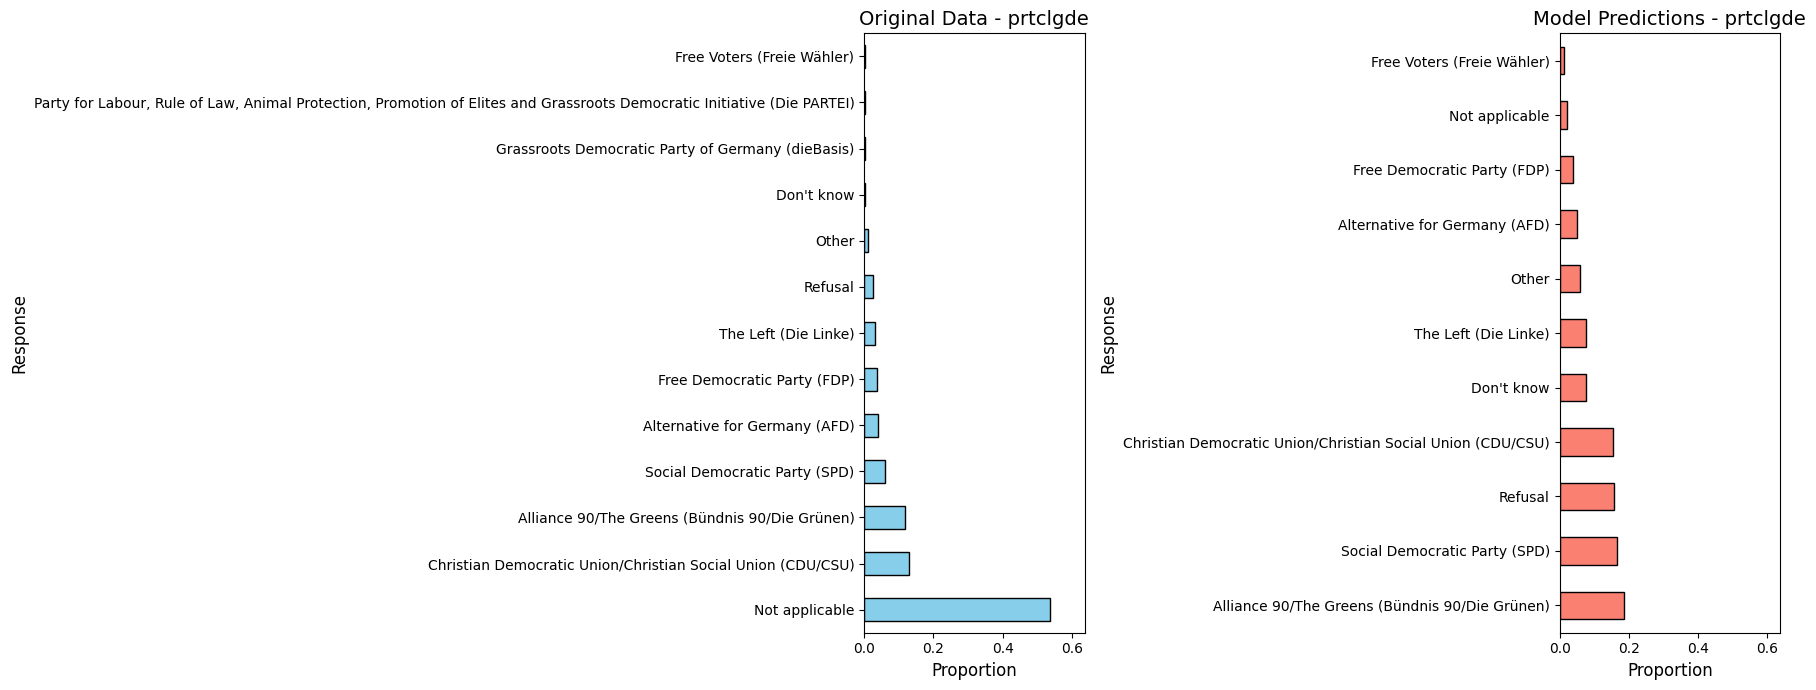

In [134]:
plot_variable_distribution(subset_germany_random, 'prtclgde', mapper, horizontal=True)